In [57]:
import csv
import json
import feather # pip install feather-format
import numpy as np
import pandas as pd
import os
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import geopandas as gpd
import ast
from sklearn import metrics
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression,LogisticRegression
import geopy.distance
%matplotlib inline
## Some utility functions
def percentToInt(percentString):
    return int(percentString.rstrip("%"))
def trueFalseToBinary(tfstring):
    return 1 if tfstring=='t' else '0'
def stringListToList(stringList):
    return ast.literal_eval(stringList)
def stringListToCount(stringList):
    return len(ast.literal_eval(stringList))
def euclideanDistance(lat1, long1, lat2, long2):
    return ((long2-long1)**2 + (lat2-lat1)**2)**(0.5)
    
reviews_data_path = "feather/reviews.feather"
listings_data_path = "feather/listings.feather"
calendar_data_path = "feather/calendar.feather"
sites_data_path = "data/sites_boston.csv"

reviews_data = pd.read_feather(reviews_data_path)
listings_data = pd.read_feather(listings_data_path)
calendar_data = pd.read_feather(calendar_data_path)
sites_data = pd.read_csv(sites_data_path)

# subway data
# https://api-v3.mbta.com/docs/swagger/index.html#/Stop
# holidays data
# https://pypi.org/project/holidays/

In [37]:
features_none_null = ["host_since","host_verifications", 
                        "host_response_rate","host_acceptance_rate",
                        "host_response_time",
                        "host_is_superhost", 
                        "latitude", "longitude",
                        "room_type", "accommodates", 
                        "amenities","minimum_nights",
                        "beds", 
                        "availability_30",	"availability_60",	"availability_90","availability_365", 
                        "number_of_reviews", "review_scores_rating", 
                        "review_scores_accuracy",	"review_scores_cleanliness",
                        "review_scores_checkin",	"review_scores_communication",
                        "review_scores_location",	"review_scores_value",
                        "instant_bookable",  "price",
                        ]
# onehot_vars = ["room_type", ]
# binary_vars = ["host_is_superhost", "instant_bookable" ]

df_none_null = listings_data.copy(deep = True)[features_none_null]
print("before droppign rows with null columns: ", df_none_null.shape)
for col in features_none_null:
    df_none_null = df_none_null[df_none_null[col].notna()]
print("after dropping rows with null columns: ", df_none_null.shape)


before droppign rows with null columns:  (3043, 27)
after dropping rows with null columns:  (1674, 27)


In [38]:

reference_date = datetime.datetime(2021,7,12)
# adding custom: host_number_of_years
host_number_of_years = [(reference_date - datetime.datetime.strptime(i, '%Y-%m-%d')).days/365
                        for i in df_none_null['host_since']]
df_none_null["host_number_of_years"] = host_number_of_years
df_none_null = df_none_null.drop(['host_since'], axis=1)
df_none_null['price'] = df_none_null['price'].map(lambda x:float(x[1:].replace(',', ''))).astype('int32')
# host reposnse rate; remove % sign, convert to integer
df_none_null['host_response_rate'] = df_none_null['host_response_rate'].map(percentToInt).astype('int32')
#  host_acceptance_rate:
df_none_null['host_acceptance_rate'] = df_none_null['host_acceptance_rate'].map(percentToInt).astype('int32')

host_response_time_dummies = pd.get_dummies(df_none_null['host_response_time'],prefix='host_response_time')
df_none_null = pd.concat([df_none_null,host_response_time_dummies], axis = 1)
df_none_null = df_none_null.drop(['host_response_time'], axis=1)

# host_is_superhost: t/f to binary
df_none_null['host_is_superhost'] = df_none_null['host_is_superhost'].map(trueFalseToBinary).astype('int32')
# "host_verifications",
df_none_null['host_verifications'] = df_none_null['host_verifications'].map(stringListToCount).astype('int32')

room_type_dummies = pd.get_dummies(df_none_null['room_type'],prefix='room_type')
df_none_null = pd.concat([df_none_null,room_type_dummies], axis = 1)
df_none_null = df_none_null.drop(['room_type'], axis=1)

df_none_null['amenities'] = df_none_null['amenities'].map(stringListToCount).astype('int32')
# "availability_30",
df_none_null['availability_30'] = df_none_null['availability_30']/30.0
# "availability_60",
df_none_null['availability_60'] = df_none_null['availability_60']/60.0
# "availability_90",
df_none_null['availability_90'] = df_none_null['availability_90']/90.0
# "availability_365", 
df_none_null['availability_365'] = df_none_null['availability_365']/365.0

df_none_null['instant_bookable'] = df_none_null['instant_bookable'].map(trueFalseToBinary).astype('int32')

print("after processing", df_none_null.shape)
# df_none_null.dtypes

after processing (1674, 33)


In [52]:
sites_data.head()

,Place,Address,Website,Latitude,Longitude
0,Harvard University,"Cambridge, MA 02138",https://www.harvard.edu,42.374740,-71.118838
1,Massachusetts Institute of Technology (MIT),"77 Massachusetts Ave, Cambridge, MA 02139",http://web.mit.edu/,42.360095,-71.096349
2,Hatch Memorial Shell,"47 David G Mugar Way, Boston, MA 02108",http://hatchshell.com/,42.357293,-71.075888
3,Boston Common,"1B Charles St, Boston, MA 02116",https://www.boston.gov/departments/parks-and-r...,42.355094,-71.067920
4,Massachusetts State House,"24 Beacon St, Boston, MA 02133",http://www.malegislature.gov/,42.358781,-71.066004


In [61]:
# Sites features Engineered

landmarks=sites_data["Place"]
landmarks_lats = sites_data["Latitude"]
landmarks_longs = sites_data["Longitude"]

# pending further considerations
def RMeanSquared(list_distances):
    output = []
    for i in list_distances:
        output.append(i**2)
    return np.sqrt(np.mean(output))

result = []

for i in range(len(df_none_null.index)):
    dist_to_each_landmark = []
    for j, landmark in enumerate(landmarks):
        # euclideanDistance(lat1, long1, lat2, long2)
        lat1,long1 = landmarks_lats[j],landmarks_longs[j]
        lat2,long2 =df_none_null.iloc[i].latitude,df_none_null.iloc[i].longitude
        # dist_to_each_landmark.append(euclideanDistance(lat1, long1, lat2, long2))
        dist_to_each_landmark.append(geopy.distance.distance((lat1, long1),(lat2, long2)).km)
    # result.append(min(dist_to_each_landmark))
    result.append(RMeanSquared(dist_to_each_landmark))

df_none_null["closeness_to_landmark"] = result

# for index, row in df_none_null.iterrows():
#     print(index)

In [134]:
outlier_removed = df_none_null[(np.abs(stats.zscore(df_none_null['price'])) < 3)]
interested_var_df = outlier_removed[["closeness_to_landmark", "price"]]
interested_var_df.corr()

,closeness_to_landmark,price
closeness_to_landmark,1.00000,-0.27197
price,-0.27197,1.00000


In [105]:
# process subway json

import simplejson as json
subway_data_path = "data/transport/subway.json"
# attributes.name .longitude .latitude .description
# id
# within attributes.description , there is Red Blue Green Orange Line info

subway_names = []
subway_lines = []
subway_lats = []
subway_longs = []
with open(subway_data_path) as f:
    subway_data = json.load(f)['data']
    for i in subway_data:
        subway_names.append(i['attributes']['name'])
        subway_lats.append(i['attributes']['latitude'])
        subway_longs.append(i['attributes']['longitude'])
        if("Red Line" in i['attributes']['description']):
            subway_lines.append("r")
            # print(i['attributes']['description'])
        elif("Blue Line" in i['attributes']['description']):
            subway_lines.append("b")
        elif("Orange Line" in i['attributes']['description']):
            subway_lines.append("o")
        else:
            subway_lines.append(None)


result = []

for i in range(len(df_none_null.index)):
    dist_to_each_subway = []
    for j, subway in enumerate(subway_names):
        # euclideanDistance(lat1, long1, lat2, long2)
        lat1,long1 = subway_lats[j],subway_longs[j]
        lat2,long2 =df_none_null.iloc[i].latitude,df_none_null.iloc[i].longitude
        dist_to_each_subway.append(geopy.distance.distance((lat1, long1),(lat2, long2)).km)
    result.append(min(dist_to_each_subway))

df_none_null["closeness_to_subway"] = result

        


In [108]:
min(df_none_null["closeness_to_subway"])

0.0062553124186862635

(0.0, 1000.0)

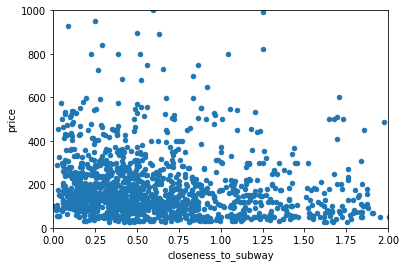

In [132]:
plot = df_none_null.plot.scatter(x="closeness_to_subway", y="price")
plot.set_xlim([0,2])
plot.set_ylim([0,1000])

In [125]:
outlier_removed = df_none_null[(np.abs(stats.zscore(df_none_null['price'])) < 3)]
interested_var_df = outlier_removed[["closeness_to_subway", "price"]]
interested_var_df.corr()

,closeness_to_subway,price
closeness_to_subway,1.000000,-0.180812
price,-0.180812,1.000000


In [ ]:
# standardization
# https://www.analyticsvidhya.com/blog/2020/04/feature-scaling-machine-learning-normalization-standardization/
# https://stackoverflow.com/questions/26414913/normalize-columns-of-pandas-data-frame
# normalized_df=(df-df.mean())/df.std()
# normalized_df=(df-df.min())/(df.max()-df.min())